# Master's Degree Courseload Optimizer

## Setup

### Libraries

In [1]:
import os, warnings, pickle
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from datetime import datetime
from scipy.optimize import minimize, Bounds, LinearConstraint
from sklearn.linear_model import LinearRegression
from os.path import join as pjoin

try:
    from tqdm import tqdm
except ModuleNotFoundError:
    # Nice to have, but not essential
    tqdm = lambda a: a

### Constants

In [2]:
# Model constants
A, B = -10., 1.
# Timeout setting ('None' to run full optimization)
TIMEOUT_AFTER_BC = 30
TIMEOUT_AFTER_IA = None
# Paths
DATA_DIR = "data"
DATA_PATH = pjoin(DATA_DIR, "data.csv")
BONUSES_PATH = pjoin(DATA_DIR, "bonus-matrix.csv")
# Save long-to-compute results separately
BC_POLICY_PATH = pjoin(DATA_DIR, "bc_policy.pkl")
IA_POLICY_PATH = pjoin(DATA_DIR, "ia_policy.pkl")

### Data

In [3]:
# Data
DATA = pd.read_csv(DATA_PATH, index_col=0)
N = DATA.shape[0]
print(f"Number of courses: {N}\n")
print(DATA)
BONUSES = pd.read_csv(BONUSES_PATH, index_col=0).to_numpy()
print(f"\nBonuses:\n{BONUSES}")

Number of courses: 12

                                   Description  Credits  Automne  Hiver
Cours                                                                  
ECN6573                    Économie financière        3        1      0
ECN6578     Économétrie des marchés financiers        3        0      1
IFT6390  Fondements de l'apprentissage machine        4        1      1
IFT6521                Programmation dynamique        4        0      1
IFT6561     Simulation : aspects stochastiques        4        1      0
MAT6470                    Calcul scientifique        3        0      1
MAT6717                           Probabilités        3        1      0
MAT6798                    Calcul stochastique        3        0      1
ACT6230                   Finance mathématique        3        1      0
ECN6238                       Macroéconométrie        3        0      1
STT6615                  Séries chronologiques        3        1      0
FMC6000                                  

## Data container

In [4]:
class DataContainer():

    def __init__(self,
                 size: int = N,
                 starting_semester: int = 0,
                 data: pd.DataFrame = DATA,
                 bonus_matrix: np.ndarray = BONUSES,
                 weight_col: str = "Credits",
                 avail_cols: list = ["Automne", "Hiver"],
                 *args, **kwargs):
        self.n = size
        self.start = starting_semester
        self.weights = data[weight_col].to_numpy()[:self.n]
        self.availability = data[avail_cols].iloc[:self.n].to_numpy()
        self.bonuses = bonus_matrix[:self.n, :self.n] - np.eye(self.n)
        self.names = data.index[:self.n]
        self.poss_states = None
        self.poss_bonuses = None
        self.poss_transitions = None
        self.reset()

    def reset(self):
        self.state = np.array([self.start, *np.zeros(self.n)])

    def flip_semester(self, X: np.ndarray = None):
        X = self.state if X is None else X.copy()
        X[0] = 1 - X[0]
        return X

    def get_possible_states(self):
        if self.poss_states is None:
            self.poss_states = np.array([
                *it.product([0,1], repeat=self.n+1)
                ])
        return self.poss_states
    
    def get_possible_bonuses(self):
        if self.poss_bonuses is None:
            self.poss_bonuses = self.get_possible_states()[:, 1:].dot(self.bonuses)
        return self.poss_bonuses
    
    def get_state_index(self, X: np.ndarray=None):
        X = self.state if X is None else X
        eq_matrix = X[np.newaxis] == self.get_possible_states()
        index = np.where(eq_matrix.all(axis=1))[0]
        assert len(index) == 1, f"Unresolved state index! State: {X}"
        return index[0]
    
    def get_possible_transitions(self, verbose: bool = False):
        if self.poss_transitions is None:
            states = self.get_possible_states()
            k = states.shape[0]
            _k = int(k / 2)
            assert k == 2**(self.n + 1), "Possibilities shape error!"
            # Shorthands
            I = lambda n, d: np.ones((n, d))
            Z = lambda n, d: np.zeros((n, d))
            concat = lambda *a, **ka: np.concatenate(*a, **ka)
            # Initialize the main matrix, initialize absorbing states
            base_matrix = I(k, k)
            base_matrix[[_k-1, -1]] = 0.
            base_matrix[[_k-1, -1], [-1, _k-1]] = 1.
            # Filter cases where we would transition to the same semester
            semester_filter = concat([Z(_k, _k), I(_k, _k)], 1)
            semester_filter = concat([semester_filter, semester_filter[:, ::-1]], 0)
            # Filter cases where already-passed courses disappear
            passed = states[:_k, 1:]
            unpass_filter = np.array([
                np.all(passed >= case[np.newaxis], axis=1)
                for case in passed
            ] * 2) * 1
            unpass_filter = concat([unpass_filter, unpass_filter], 1)
            # Filter cases where the transition would require passing
            # a course that is not available in current-state semester
            availability_filter = Z(k, k)
            idx_sets = [np.arange(_k), np.arange(_k, k)]
            slices = [slice(_k,k), slice(_k)]
            for semester in [0, 1]:
                I, J = idx_sets[semester], idx_sets[1-semester]
                comparisons = np.array([
                    states[J, 1:] - _state[1:][np.newaxis]
                    for _state in states[I]
                ]) <= self.availability[:, semester]
                availability_filter[I, slices[semester]] = comparisons.all(-1) * 1
            if verbose:
                print(f"Base matrix:\n{base_matrix}")
                print(f"Semester filter:\n{semester_filter}")
                print(f"Passed cases:\n{passed}")
                print(f"'Unpassing' filter:\n{unpass_filter}")
                print(f"Availability filter:\n{availability_filter}")
            self.poss_transitions = (
                base_matrix
                *semester_filter
                *unpass_filter
                *availability_filter
                ).astype(int)
        return self.poss_transitions

toy_problem = DataContainer(size=2)
# Validation: static transition possibilities generator
print("\nToy problem, possibilities matrix creation:")
toy_problem.get_possible_transitions(verbose=True)


Toy problem, possibilities matrix creation:
Base matrix:
[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]
Semester filter:
[[0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]]
Passed cases:
[[0 0]
 [0 1]
 [1 0]
 [1 1]]
'Unpassing' filter:
[[1 1 1 1 1 1 1 1]
 [0 1 0 1 0 1 0 1]
 [0 0 1 1 0 0 1 1]
 [0 0 0 1 0 0 0 1]
 [1 1 1 1 1 1 1 1]
 [0 1 0 1 0 1 0 1]
 [0 0 1 1 0 0 1 1]
 [0 0 0 1 0 0 0 1]]
Availability filter:
[[0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]]


array([[0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0]])

In [5]:
std_problem = DataContainer()
print(f"State index 0: {std_problem.state}")
print(f"Course weights: {std_problem.weights}")
print(std_problem.get_possible_transitions().mean(1))

State index 0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Course weights: [3 3 4 4 4 3 3 3 3 3 3 9]
[0.015625   0.0078125  0.0078125  ... 0.00012207 0.00024414 0.00012207]


## Course-passing probability

3     0.999089
4     0.997527
6     0.982014
7     0.952574
8     0.880797
9     0.731059
12    0.119203
Name: Pr(w=1|v), dtype: float64


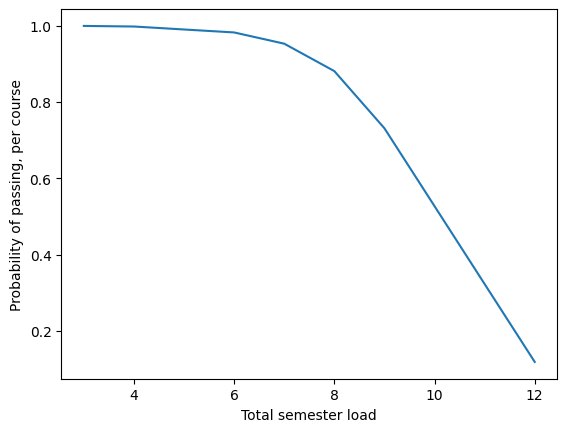

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(x))

def f_w(v: np.ndarray, 
        a: float = A,
        b: float = B,
        eps: float = 1e-2, # Overflow encountered if much smaller
        bonus: np.ndarray = 0.,
        *args, **kwargs):
    prob = sigmoid(a + b / np.maximum(eps, v) + bonus)
    # The impossibility of zero probabilities is a consequence of
    # the bounding of v, so we need to reintroduce zeroes
    prob[np.isclose(prob, 0)] = 0
    return prob

loads = [*it.combinations_with_replacement(
    [0, *np.unique(std_problem.weights)], 2)]
loads = np.array([*{sum(l) for l in loads if 0 < sum(l) <= 12}])
f_w_conditional = pd.Series(f_w(1 / loads), index=loads, name="Pr(w=1|v)")
print(f_w_conditional)

plt.plot(f_w_conditional)
plt.xlabel("Total semester load")
plt.ylabel("Probability of passing, per course")
plt.show()

## Control environment

In [7]:
def binary_array(size: int, ones_at: np.ndarray=[]): # Helper function
    arr = np.zeros(size)
    arr[ones_at] = 1.
    return arr

class ControlEnvironment():

    def __init__(self,
                 data: DataContainer,
                 increment_cost: float = 4.,
                 compl_criterion: callable = (lambda x: x == 1),
                 **kwargs):
        self.data = data
        self.increment = increment_cost
        self.compl_criterion = compl_criterion
        self._done = False

    def reset(self):
        self.data.reset()
        self._done = False

    def get_valid_choices(self, X: np.ndarray=None):
        X = self.data.state if X is None else X
        if np.ndim(X) == 1:
            semester = X[0]
            completed = X[1:]
            available = self.data.availability[:, int(semester)]
        else:
            semester = X[:, 0].astype(int)
            completed = X[:, 1:]
            avail = self.data.availability
            available = np.array([
                avail[np.repeat(i, semester.shape[0]), semester]
                for i in range(completed.shape[1])
            ]).T
        return np.squeeze((1 - completed) * available)
    
    def validate_choices(self, choices: np.ndarray, **kwargs):
        valid = self.get_valid_choices(**kwargs)
        if np.any(valid - choices < 0):
            print(f"'passed' argument:\n{choices}\nValid:\n{valid}")
            raise ValueError(f"Invalid course selection!: {choices}")
    
    def get_current_bonuses(self, X: np.ndarray=None):
        if X is None:
            X = self.data.state.copy()
        if np.ndim(X) == 1:
            X = X[np.newaxis]
        return np.squeeze(X[:, 1:].dot(self.data.bonuses))
    
    def update_state(self, passed: np.ndarray=None):
        # We expect either N-length binary vector, or a vector
        # of indices
        data = self.data
        passed = np.zeros(data.n) if passed is None \
            else passed.squeeze()
        if np.any(~np.in1d(passed, [0,1])):
            assert np.all(passed >= 0), passed
            assert np.all(passed < data.n), passed
            passed = binary_array(data.n, passed)
        elif len(passed) != data.n:
            error_msg = " ".join([
                "'passed' argument should be a vector of indices,",
                f"or a binary vector of length {data.n}. Current",
                f"value: {passed} (length: {len(passed)})"
            ])
            raise ValueError(error_msg)
        # Ensure the courses passed are valid
        self.validate_choices(passed)
        # If everything's good, update the state!
        data.flip_semester()
        data.state[1:] += passed

    def transition_prob(self,
                        v_t: np.ndarray,
                        success_prob: callable = f_w,
                        **kwargs):        
        weights = self.data.weights
        bonus = self.get_current_bonuses(**kwargs)
        return success_prob(v_t/weights, bonus=bonus, **kwargs)
    
    def transition(self,
                   u_t: np.ndarray,
                   v_t: np.ndarray,
                   **kwargs):
        if u_t.sum() > 0:
            w_t = np.random.binomial(
                n = 1, 
                p = self.transition_prob(v_t=v_t, **kwargs)
            )
        else:
            w_t = np.zeros_like(u_t)
        self.update_state(passed=w_t)

    def compute_progress(self):
        weights = self.data.weights
        completed = weights.dot(self.data.state[1:])
        return completed / weights.sum()
    
    def done(self):
        self._done = self.compl_criterion(self.compute_progress())
        return self._done

    def step_cost(self, state: np.ndarray=None):
        if state is None:
            state = self.data.state
        # Going from the winter to the fall semester is more costly,
        # since there are an extra four months in between
        incr = self.increment
        I_norm = state[1:].sum()
        if I_norm == self.data.n:
            cost = 0
        elif state[0] == 0 and I_norm > 0:
            cost = 2 * incr
        else:
            # We will assume that the case where I_norm == 0 and
            # the current semester is Fall means that this is the
            # first semester, rather than a carryover after failing
            # to pass any courses in the previous Winter semester
            cost = incr
        return cost
    
    def __str__(self):
        data = self.data
        done = int(data.state[1:].dot(data.weights))
        return "\n".join([
            f"State:\t\t\t{data.state.astype(int)}",
            f"Feasible choices:\t  {self.get_valid_choices().astype(int)}",
            f"Bonuses:\t\t{self.get_current_bonuses()}",
            f"Credits completed:\t{done}",
            f"Credits left:\t\t{int(data.weights.sum()) - done}"
        ])
    
std_problem.reset()
std_env = ControlEnvironment(std_problem)
print(std_env)
std_env.update_state()
print(f"\nAfter update:\n{std_env}")

toy_problem = DataContainer(size=3) # Let's overwrite the N=2 case... TOO small!
toy_env = ControlEnvironment(toy_problem)

State:			[0 0 0 0 0 0 0 0 0 0 0 0 0]
Feasible choices:	  [1 0 1 0 1 0 1 0 1 0 1 1]
Bonuses:		[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Credits completed:	0
Credits left:		45

After update:
State:			[1 0 0 0 0 0 0 0 0 0 0 0 0]
Feasible choices:	  [0 1 1 1 0 1 0 1 0 1 0 1]
Bonuses:		[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Credits completed:	0
Credits left:		45


## Policies

In [32]:
class Policy(ABC):

    def __init__(self, env: ControlEnvironment):
        self.env = env
        self.n = env.data.n
        n_states = 2 ** (self.n + 1)
        self.J = np.zeros(n_states)
        self.v = np.zeros((n_states, self.n))
        self.loaded = False
        self.fitted = {}
        self.prefitted = {}

    def save(self, path: str, **extras):
        with open(path, "wb") as f:
            pickle.dump({
                "v": self.v, 
                "J": self.J, 
                "fitted": self.fitted,
                **extras
            }, f)

    def load(self, path: str):
        with open(path, "rb") as f:
            args = pickle.load(f)
        for k, v in args.items():
            self.__dict__[k] = v
        self.loaded = True
        if "fitted" in args:
            self.prefitted = args["fitted"]

    def as_df(self):
        data = self.env.data
        states = data.get_possible_states()
        semester = pd.Series(
            np.vectorize(lambda x: "Winter" if x else "Fall")(states[:, 0]),
            name = "semester"
            ).to_frame()
        states = pd.DataFrame(
            states[:, 1:], 
            columns = [n + "_Done" for n in data.names],
        )
        policy = pd.DataFrame(self.v, columns=data.names)
        return pd.concat([semester, states, policy], axis=1)
    
    def train(self, **kwargs):
        pass

    @abstractmethod
    def allocate_time(self):
        pass

### Random Policy

In [9]:
class RandomPolicy(Policy):

    def select_courses(self, n: int=None, **kwargs):
        valid = self.env.get_valid_choices()
        n_valid = int(valid.sum())
        if n_valid > 0:
            if n is None:
                n = np.random.randint(low=1, high=n_valid+1)
            choices = np.random.choice(
                np.where(valid)[0],
                size = min(n, self.n, n_valid),
                replace = False
            ).astype(int)
        else:
            choices = []
        return binary_array(
            size = self.n,
            ones_at = choices
        )
    
    def allocate_time(self, selection: np.ndarray=None, **kwargs):
        if selection is None:
            selection = self.select_courses(**kwargs)
        alloc = np.random.uniform(size=self.n) * selection
        if selection.any():
            alloc /= alloc.sum()
        return alloc
    
random_policy = RandomPolicy(env=std_env)
allocations = random_policy.allocate_time()
print(np.round(allocations, 3))

pol_df = random_policy.as_df()
print(pol_df.shape)
pol_df.head()

[0.    0.079 0.187 0.049 0.    0.336 0.    0.193 0.    0.    0.    0.157]
(8192, 25)


,semester,ECN6573_Done,ECN6578_Done,IFT6390_Done,IFT6521_Done,IFT6561_Done,MAT6470_Done,MAT6717_Done,MAT6798_Done,ACT6230_Done,...,IFT6390,IFT6521,IFT6561,MAT6470,MAT6717,MAT6798,ACT6230,ECN6238,STT6615,FMC6000
0,Fall,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Fall,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Fall,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Fall,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Fall,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Control episode

In [10]:
class ControlEpisode():

    def __init__(self,
                 env: ControlEnvironment, 
                 policy: Policy = None,
                 **kwargs):
        self.env = env
        self.policy = policy
        self.reset(**kwargs)

    def reset(self, state_also: bool=True):
        self.cost = 0
        if state_also:
            self.env.data.reset()
    
    def step(self, verbose: bool=False, **kwargs):
        v_t = self.policy.allocate_time(**kwargs)
        u_t = (v_t > 0).astype(int)
        if verbose:
            choices = np.where(u_t)[0]
            print("\n".join([
                f"\nChoices:\t{choices}",
                f"Allocations:\t{np.round(v_t[choices], 4)}"
            ]))
        self.env.transition(u_t, v_t, **kwargs)
        self.cost += self.env.step_cost()

    def episode(self, verbose: bool=False):
        self.reset(state_also=True)
        while not self.env.done():
            self.step(verbose=verbose)
            if verbose:
                msg = str(self.env) + f"\nCumulative cost: {self.cost}"
                print(msg)
        return self.cost

episode_control = ControlEpisode(
    env = std_env,
    policy = random_policy
)
_ = episode_control.episode(verbose=True)


Choices:	[ 0  4  8 11]
Allocations:	[0.3208 0.1186 0.058  0.5026]
State:			[1 1 0 0 0 0 0 0 0 0 0 0 0]
Feasible choices:	  [0 1 1 1 0 1 0 1 0 1 0 1]
Bonuses:		[0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
Credits completed:	3
Credits left:		42
Cumulative cost: 4.0

Choices:	[ 2 11]
Allocations:	[0.1497 0.8503]
State:			[0 1 0 0 0 0 0 0 0 0 0 0 0]
Feasible choices:	  [0 0 1 0 1 0 1 0 1 0 1 1]
Bonuses:		[0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
Credits completed:	3
Credits left:		42
Cumulative cost: 12.0

Choices:	[ 2  4  8 10 11]
Allocations:	[0.1071 0.4063 0.1665 0.2843 0.0358]
State:			[1 1 0 0 0 1 0 0 0 0 0 1 0]
Feasible choices:	  [0 1 1 1 0 1 0 1 0 1 0 1]
Bonuses:		[0.  0.3 0.2 0.1 0.  0.  0.  0.  0.  0.2 0.  0. ]
Credits completed:	10
Credits left:		35
Cumulative cost: 16.0

Choices:	[2 5 9]
Allocations:	[0.2809 0.0734 0.6458]
State:			[0 1 0 0 0 1 0 0 0 0 1 1 0]
Feasible choices:	  [0 0 1 0 0 0 1 0 1 0 0 1]
Bonuses:		[0.  0.5 0.4 0.1 0.  0.  0.  0.  0.  0.2 0.2 0. ]


## Exact optimization

### Transition probability vector

In [11]:
def transition_probs(v_t: np.ndarray,
                     env: ControlEnvironment,
                     state: np.ndarray = None,
                     **kwargs):
    u_t = (v_t > 0) * 1
    env.validate_choices(choices=u_t, X=state)
    data = env.data
    if state is None:
        state = data.state
    # Define which next-step states are feasible
    current = state[1:]
    ns_states = data.get_possible_states()
    possible = np.array([
        np.all(state <= current + u_t)
        for state in ns_states[:, 1:]
    ]) * data.get_possible_transitions()[data.get_state_index(X=state)]
    cases = ns_states[np.where(possible)[0]][:, 1:] - current[np.newaxis]
    # Compute individual course-passing probabilities
    p = env.transition_prob(v_t=v_t, X=state)[np.newaxis]
    # Compute joint case probabilities
    case_probs = np.product(
        p * cases + (1-p) * (1-cases),
        axis = 1
    )
    # Expand to match transition-matrix shape
    pr_vector = np.zeros_like(possible).astype(float)
    pr_vector[np.where(possible)[0]] = case_probs
    assert np.isclose(1, case_probs.sum()), \
        f"Shape: {case_probs.shape}; Sum: {case_probs.sum()}"
    return pr_vector

toy_policy = RandomPolicy(env=toy_env)
pr = transition_probs(
    env = toy_env, 
    v_t = toy_policy.allocate_time(np.array([1,0,1]))
)
np.round(pr, 3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.003,
       0.997, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

### Single-step cost optimization

In [12]:
def optimize_cost(valid: np.ndarray, 
                  state: np.ndarray, 
                  i: int, 
                  cost_func: callable, 
                  g: float = None,
                  J: np.ndarray = None,
                  verbose: bool = False,
                  eps: float = 1e-5,
                  **kwargs):
    valid = np.squeeze(valid)
    assert np.ndim(valid) == 1,\
        f"'valid' argument needs to be 1-dimensional, current shape: {valid.shape}"
    first_guess = valid / max(1., valid.sum())
    func_args = (valid, state, i, g, J)
    if np.sum(first_guess > 0) <= 1:
        v = first_guess
    else:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            d = len(first_guess)
            optim_args = { # Saved in a dictionary for easier debugging
                "fun": cost_func,
                "x0": first_guess,
                "args": func_args,
                "bounds": Bounds(lb=0., ub=1),
                "constraints": [
                    LinearConstraint(A=np.ones(d), lb=1., ub=1.),
                    LinearConstraint(A=np.eye(d), lb=0., ub=valid+eps)
                ]
            }
            optim = minimize(**optim_args)
        v = optim.x * valid
        v /= v.sum()
        if verbose:
            print(f"\n\t".join([
                "Optimization...",
                f"Worked: {optim.success}",
                f"Result: {v}"]))
        if not optim.success:
            print(f"Optimization didn't work!!!\n{optim}")
    _J = cost_func(v, *func_args, verbose=verbose)
    return v, _J

### Back-chain policy

In [27]:
class BackChainPolicy(Policy):

    def allocate_time(self, *args, **kwargs):
        i = self.env.data.get_state_index()
        return self.v[i]
    
    def expected_cost(self,
                      v_t: np.ndarray,
                      valid: np.ndarray,
                      state: np.ndarray,
                      state_index: int = None, # Compatibility placeholder
                      g: float = 0.,
                      J: np.ndarray = None,
                      **kwargs):
        if J is None:
            J = self.J
        v_t = np.minimum(v_t, valid)
        p = transition_probs(v_t, env=self.env, state=state, **kwargs)
        return g + p.dot(J)

    def pair_optimization(self, 
                          pair: np.ndarray, 
                          indices: list, 
                          eps: float = 1e-5,
                          max_iter: int = 10,
                          verbosity: int = 0,
                          **kwargs):
        J = self.J.copy()
        env = self.env
        g = [env.step_cost(state=p.squeeze()) for p in pair]
        choices = np.array([
            env.get_valid_choices(X=p)
            for p in pair
            ])
        for _ in range(max_iter):
            converged = [0, 0]
            for m in [0, 1]:
                i = indices[m]
                self.v[i], _J = optimize_cost(
                    valid = choices[m],
                    state = pair[m],
                    i = i,
                    cost_func = self.expected_cost,
                    g = g[m],
                    J = J,
                    verbose = verbosity > 1
                )
                converged[m] = abs(_J - J[i]) < eps
                J[i] = _J
            if np.all(converged):
                break
        if verbosity > 0:
            print(f"J = {np.round(J,4)}")
        self.J = J

    def train(self,
              verbosity: int = 0, 
              time_limit: int = None,
              warm_start: str = None,
              save_to: str = None,
              **kwargs):
        timeout = False
        if time_limit is not None:
            start = datetime.now()
        data = self.env.data
        possible = data.get_possible_states()
        K = possible[:, 1:].sum(1)
        N = self.n
        if verbosity > 0:
            print(f"Backchain from N={N}")
        if warm_start is not None:
            try:
                if not self.loaded:
                    self.load(warm_start)
                if verbosity > 0:
                    print(f"Loaded warm start from {warm_start}")
            except FileNotFoundError:
                if verbosity > 0:
                    print(f"Could not load {warm_start}!")
        for k in np.arange(N - 1, -1, -1):
            if timeout:
                raise TimeoutError("This is taking too long!")
            if self.fitted.get(k, False):
                continue
            iterator = possible[np.where(K == k)[0]]
            iterator = iterator[:int(iterator.shape[0] / 2)]
            if verbosity > 0:
                print(f"\nk == {k}: {len(iterator)} pairs")
                iterator = tqdm(iterator)
            for X in iterator:
                if time_limit is not None:
                    elapsed = (datetime.now() - start).seconds
                    timeout = elapsed >= time_limit
                    if timeout:
                        break
                i = data.get_state_index(X)
                indices = [i, i + 2 ** N]
                pair = possible[indices]
                self.pair_optimization(
                    pair, 
                    indices, 
                    verbosity = verbosity - 1,
                    **kwargs
                )
            self.fitted[k] = True
            if save_to is not None:
                self.save(path=save_to)
            if verbosity > 1:
                print(f"Estimated values: {self.J}")

toy_bc_policy = BackChainPolicy(toy_env)
toy_bc_policy.train(verbosity=1)
print("\nPolicy by state:")
toy_bc_policy.as_df()

Backchain from N=3

k == 2: 3 pairs


100%|██████████| 3/3 [00:00<00:00, 602.25it/s]



k == 1: 3 pairs


100%|██████████| 3/3 [00:00<00:00, 100.33it/s]



k == 0: 1 pairs


100%|██████████| 1/1 [00:00<00:00, 50.17it/s]


Policy by state:


,semester,ECN6573_Done,ECN6578_Done,IFT6390_Done,ECN6573,ECN6578,IFT6390
0,Fall,0,0,0,0.503155,0.000000,0.496845
1,Fall,0,0,1,1.000000,0.000000,0.000000
2,Fall,0,1,0,0.472750,0.000000,0.527250
3,Fall,0,1,1,1.000000,0.000000,0.000000
4,Fall,1,0,0,0.000000,0.000000,1.000000
5,Fall,1,0,1,0.000000,0.000000,0.000000
6,Fall,1,1,0,0.000000,0.000000,1.000000
7,Fall,1,1,1,0.000000,0.000000,0.000000
8,Winter,0,0,0,0.000000,0.493014,0.506986
9,Winter,0,0,1,0.000000,1.000000,0.000000


### Comparison to random policy

In [38]:
def compare_policies(env: ControlEnvironment,
                     policy_types: dict = {
                        "random": RandomPolicy,
                        "backchain": BackChainPolicy},
                     policies: dict = {},
                     n_sim: int = 1000,
                     verbosity: int = 0,
                     *args, **kwargs):
    
    if len(policies) < len(policy_types):
        for _type, policy_type in policy_types.items():
            if _type in policies:
                continue
            if verbosity > 0:
                print(f"\nInstantiating and training {_type} policy...")
            policies[_type] = policy_type(env=env, **kwargs)
            policies[_type].train(verbosity=verbosity-1, **kwargs)
    
    perfs = {}
    for _type, policy in policies.items():
        if verbosity > 0:
            print(f"\nSimulating performance for {_type} policy...")
        control = ControlEpisode(env=env, policy=policy)
        iterator = range(n_sim) if verbosity <= 0 else tqdm(range(n_sim))
        perf = np.array([control.episode() for _ in iterator])
        perfs[_type] = perf
        if verbosity > 0:
            print(f"\tMean: {perf.mean()}\n\tStandard deviation: {perf.std()}")
    for k, v in perfs.items():
        plt.hist(v, alpha=.8, label=k)
    plt.title("Cost distribution")
    plt.legend()
    plt.show()

#### Toy problem


Instantiating and training random policy...

Instantiating and training backchain policy...

Simulating performance for random policy...


100%|██████████| 1000/1000 [00:00<00:00, 2733.87it/s]


	Mean: 10.44
	Standard deviation: 4.300511597473027

Simulating performance for backchain policy...


100%|██████████| 1000/1000 [00:00<00:00, 5067.34it/s]


	Mean: 4.288
	Standard deviation: 1.5839999999999999


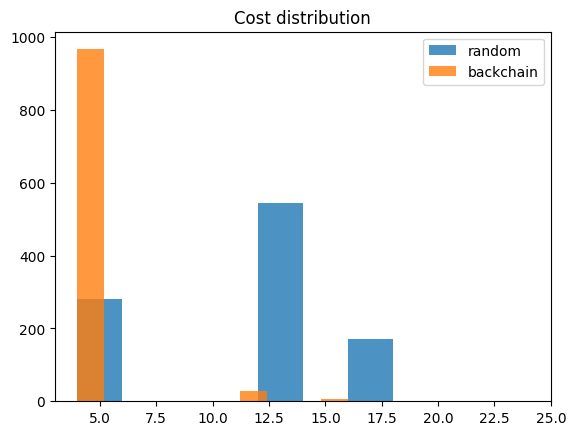

In [15]:
compare_policies(env=toy_env, verbosity=1)

#### Intermediate problem

In [16]:
interm_problem = DataContainer(size=6)

In [17]:
interm_env = ControlEnvironment(interm_problem)
interm_bc_policy = BackChainPolicy(interm_env)
interm_bc_policy.train(verbosity=1)

Backchain from N=6

k == 5: 6 pairs


100%|██████████| 6/6 [00:00<00:00, 182.45it/s]



k == 4: 15 pairs


100%|██████████| 15/15 [00:00<00:00, 19.83it/s]



k == 3: 20 pairs


100%|██████████| 20/20 [00:01<00:00, 10.82it/s]



k == 2: 15 pairs


100%|██████████| 15/15 [00:02<00:00,  7.41it/s]



k == 1: 6 pairs


100%|██████████| 6/6 [00:01<00:00,  3.57it/s]



k == 0: 1 pairs


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



Instantiating and training random policy...

Simulating performance for backchain policy...


100%|██████████| 1000/1000 [00:00<00:00, 2117.42it/s]


	Mean: 16.78
	Standard deviation: 2.4231384607570408

Simulating performance for random policy...


100%|██████████| 1000/1000 [00:00<00:00, 1266.85it/s]


	Mean: 26.972
	Standard deviation: 6.203161774450187


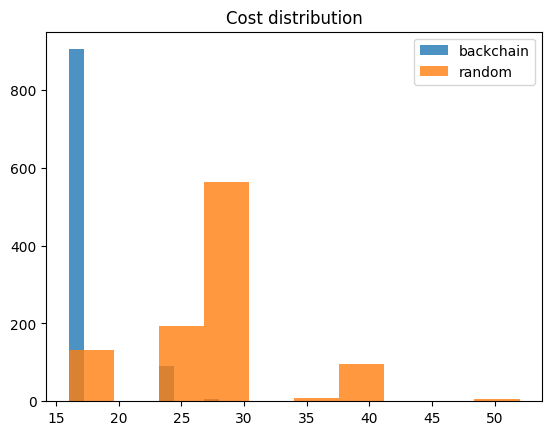

In [18]:
compare_policies(
    env = interm_env, 
    verbosity = 1,
    policies = {"backchain": interm_bc_policy}
)

## Approximation

### Iterative approximation policy

I created `compute_features` and `model_init` as standalone functions, to experiment more easily with different feature transformations.

In [19]:
def compute_features(state: np.ndarray,
                       env: ControlEnvironment, 
                       state_index: int = None,
                       **kwargs):
    data = env.data
    done = state[1:]
    if state_index is None:
        state_index = data.get_state_index(state)
    # Easy scalars
    completion_ratio = done.mean()
    current_semester = state[0]
    # Acquired bonus
    bonuses = data.bonuses.sum(1)
    potential_bonus = bonuses.sum()
    if potential_bonus > 0:
        acquired_bonus = done.dot(bonuses) / potential_bonus
    else:
        acquired_bonus = 0
    # Credits left to do
    credits_left = data.weights.dot(1 - done)
    # Possible courses this semester
    feasible_current = env.get_valid_choices(X=state)
    feasible_credits_current = data.weights.dot(feasible_current)
    return np.array([
        1., # Intercept
        credits_left,
        completion_ratio,
        current_semester,
        acquired_bonus,
        feasible_current.sum(),
        feasible_credits_current
    ])

def model_init(**kwargs):
    features = compute_features(**kwargs)
    model = np.zeros_like(features)
    model[1] = .125 # Estimating a rythm of 8 credits per semester
    return model

In [33]:
class IterativeApproximationPolicy(Policy):

    def __init__(self, 
                 feature_func: callable = compute_features, 
                 model_init_func: callable = model_init,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.feature_func = feature_func
        self.model_init_func = model_init_func
        self.models = {}
        self.features = None
        possible = self.env.data.get_possible_states()
        self.I = possible[:, 1:].sum(1)
        self.fitted = {}
        # Initial estimations equal to step costs
        self.g = np.array([
            self.env.step_cost(state=X)
            for X in possible
        ])
        self.J = self.g.copy()
        self._J_hat = self.J.copy()
        
    def allocate_time(self,
                      state: np.ndarray = None,
                      state_index: int = None,
                      **kwargs):
        if state_index is None:
            state_index = self.env.data.get_state_index(X=state)
        return self.v[state_index]
        
    def get_features(self, **kwargs):
        if self.features is None:
            possible_states = self.env.data.get_possible_states()
            self.features = [
                self.feature_func(state=state, env=self.env, **kwargs) 
                for state in possible_states
            ]
        return self.features
        
    def get_model(self, k: int=None, index: int=None, **kwargs):
        if k is None:
            k = self.I[index]
        model = self.models.get(k, None)
        if model is None:
            state = self.env.data.get_possible_states()[index]
            self.models[k] = self.model_init_func(state=state, env=self.env)
        return self.models[k]

    def compute_J_hat(self, 
                      features: np.ndarray, 
                      index: int,
                      k: int = None, 
                      **kwargs):
        model = self.get_model(index=index, **kwargs)
        return model.dot(features)
    
    def expected_cost(self,
                      v_t: np.ndarray,
                      valid: np.ndarray,
                      state: np.ndarray = None,
                      state_index: int = None,
                      g: float = None,
                      J: np.ndarray = None,
                      verbose: bool = False,
                      **kwargs):
        env = self.env
        data = env.data
        if J is None:
            J = self.J
        v_t = np.minimum(v_t, valid)
        if state is None:
            state = data.state
        if state_index is None:
            state_index = data.get_state_index(state)
        transitions = data.get_possible_transitions()[state_index]
        indices = np.where(transitions)[0]
        J_hat_ns = self._J_hat[indices]
        p = transition_probs(v_t=v_t, env=env, state=state, **kwargs)
        return g + p[indices].dot(J_hat_ns)
    
    def simulated_cost(self,
                       state: np.ndarray,
                       state_index: int = None,
                       **kwargs):
        env = self.env
        data = env.data
        if state_index is None:
            state_index = data.get_state_index(state)
        transitions = data.get_possible_transitions()[state_index]
        indices = np.where(transitions)[0]
        J_hat_ns = self._J_hat[indices]
        poss_choices = data.get_possible_states()[indices, 1:]
        poss_gains = np.maximum(0, poss_choices - state[1:][np.newaxis])
        v_t = poss_gains / np.maximum(1., poss_gains.sum(1, keepdims=True))
        p = np.array([
            transition_probs(
                v_t=v, 
                env=env,
                state=state, 
                **kwargs
            )[indices]
            for i, v in enumerate(v_t)
        ])
        expected_J_ns = p.dot(J_hat_ns)
        return self.g[state_index] + min(expected_J_ns)
    
    def refine_policy(self, verbose: bool=True):
        env = self.env
        data = env.data
        possible_states = data.get_possible_states()
        choices = env.get_valid_choices(X=possible_states)
        if verbose:
            print("\nRefining policy...")
            possible_states = tqdm(possible_states)
        self.v = np.array([
            optimize_cost(
                    valid = choices[i],
                    state = state,
                    i = i,
                    cost_func = self.expected_cost,
                    g = self.g[i],
                    J = self.J[i]
            )[0]
            for i, state in enumerate(possible_states)
        ])

    def train(self, 
              max_iter: int = 10,
              eps: float = 1e-3,
              verbosity: int = 1,
              show_hist: bool = False,
              time_limit: int = None,
              warm_start: str = None,
              **kwargs):
        timeout = False
        if time_limit is not None:
            start = datetime.now()
        if warm_start is not None:
            try:
                if not self.loaded:
                    self.load(warm_start)
                if verbosity > 0:
                    print(f"Loaded warm start from {warm_start}")
            except FileNotFoundError:
                warm_start = False
        env = self.env
        data = env.data
        features = self.get_features(**kwargs)
        possible_states = data.get_possible_states()
        N = possible_states[:, 1:].sum(1)
        # Get 1SL approximations
        for n in np.arange(data.n-1, -1, -1):
            case_idx = np.where(N == n)[0]
            if warm_start:
                # Check if this group has already been fitted
                if self.fitted.get(n, False):
                    if verbosity > 0:
                        print(f"n == {n} => Already fitted")
                    continue
            for _ in range(max_iter):
                if verbosity > 0:
                    if _ == 0: print("")
                    end = "\n" if verbosity > 1 else ""
                    print(f"Iteration: {_+1} (n=={n})", end=end)
                    if verbosity > 2: print(f"\tcases: {case_idx}")
                if timeout:
                    raise TimeoutError("This is taking too long!")
                dataset = []                
                iterator = case_idx if verbosity < 2 else tqdm(case_idx)
                for i in iterator:
                    if time_limit is not None:
                        elapsed = (datetime.now() - start).seconds
                        timeout = elapsed >= time_limit
                        if timeout:
                            break
                    state = possible_states[i]
                    beta = self.simulated_cost(
                        state=state, 
                        state_index=i, 
                        **kwargs
                        )
                    dataset.append((features[i], beta))
                # Fit the model
                X, y = list(zip(*dataset))
                model = LinearRegression(fit_intercept=False)
                model.fit(np.array(X), np.array(y))
                self.models[n] = model.coef_
                self._J_hat[case_idx] = np.maximum(0, [
                    self.compute_J_hat(features[i], index=i, k=n)
                    for i in case_idx
                ])
                # Check convergence
                change = np.linalg.norm(self._J_hat[case_idx] - self.J[case_idx])
                self.J = self._J_hat.copy()
                if verbosity > 0:
                    print(f"  => Convergence metric: {change}")
                if change < eps:
                    break
            self.fitted[n] = True
        if verbosity > 1:
            print(f"\nEstimated costs: {self.J}")
        if not self.prefitted.get(0, False):
            self.refine_policy(verbose = verbosity > 0)
        if show_hist:
            plt.hist(self.J)
            plt.title("Distribution of $\\hat J$")
            plt.show()
   
toy_env.reset()
toy_ia_policy = IterativeApproximationPolicy(env=toy_env)
toy_ia_policy.train(verbosity=1)


Iteration: 1 (n==2)  => Convergence metric: 8.642092853834319
Iteration: 2 (n==2)  => Convergence metric: 0.5482586559718834
Iteration: 3 (n==2)  => Convergence metric: 0.1835431364570399
Iteration: 4 (n==2)  => Convergence metric: 0.06132738488763608
Iteration: 5 (n==2)  => Convergence metric: 0.02051359040657295
Iteration: 6 (n==2)  => Convergence metric: 0.006861654486759366
Iteration: 7 (n==2)  => Convergence metric: 0.002295176295362158
Iteration: 8 (n==2)  => Convergence metric: 0.0007677207059733714

Iteration: 1 (n==1)  => Convergence metric: 11.977131035016228
Iteration: 2 (n==1)  => Convergence metric: 0.6713704939347099
Iteration: 3 (n==1)  => Convergence metric: 0.001234192699791054
Iteration: 4 (n==1)  => Convergence metric: 2.664083609782712e-06

Iteration: 1 (n==0)  => Convergence metric: 5.656854249492377
Iteration: 2 (n==0)  => Convergence metric: 3.727509063469498
Iteration: 3 (n==0)  => Convergence metric: 0.007991812172966477
Iteration: 4 (n==0)  => Convergence met

100%|██████████| 16/16 [00:00<00:00, 891.93it/s]



Iteration: 1 (n==5)  => Convergence metric: 12.922211378772456
Iteration: 2 (n==5)  => Convergence metric: 0.9505133870973805
Iteration: 3 (n==5)  => Convergence metric: 0.39501409272997295
Iteration: 4 (n==5)  => Convergence metric: 0.12297899031828073
Iteration: 5 (n==5)  => Convergence metric: 0.050445350236933584
Iteration: 6 (n==5)  => Convergence metric: 0.01575533238326177
Iteration: 7 (n==5)  => Convergence metric: 0.006450567924686012
Iteration: 8 (n==5)  => Convergence metric: 0.002018231071469497
Iteration: 9 (n==5)  => Convergence metric: 0.0008248900577668303

Iteration: 1 (n==4)  => Convergence metric: 25.72568414014344
Iteration: 2 (n==4)  => Convergence metric: 3.8738658452575665
Iteration: 3 (n==4)  => Convergence metric: 0.4132944671387398
Iteration: 4 (n==4)  => Convergence metric: 0.05790452273555427
Iteration: 5 (n==4)  => Convergence metric: 0.00989235172814418
Iteration: 6 (n==4)  => Convergence metric: 0.0016691220678745873
Iteration: 7 (n==4)  => Convergence m

100%|██████████| 128/128 [00:02<00:00, 56.83it/s]


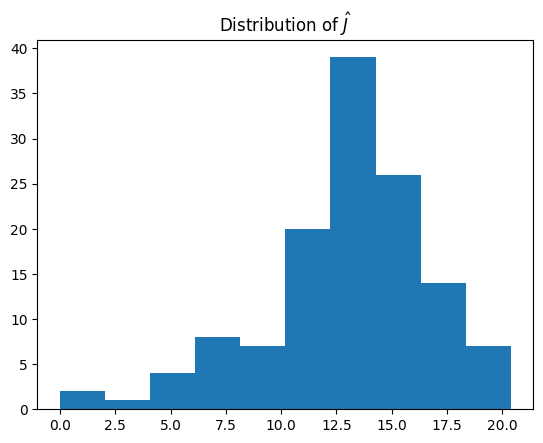

In [21]:
interm_env.reset()
interm_env = ControlEnvironment(interm_problem)
interm_ia_policy = IterativeApproximationPolicy(env=interm_env)
interm_ia_policy.train(verbosity=1, show_hist=True)

## Comparison: exact vs. approximate

### Toy problem


Simulating performance for exact policy...


100%|██████████| 1000/1000 [00:00<00:00, 4251.44it/s]


	Mean: 4.352
	Standard deviation: 1.7538802695737248

Simulating performance for approximate policy...


100%|██████████| 1000/1000 [00:00<00:00, 3997.38it/s]


	Mean: 4.272
	Standard deviation: 1.5459676581351889


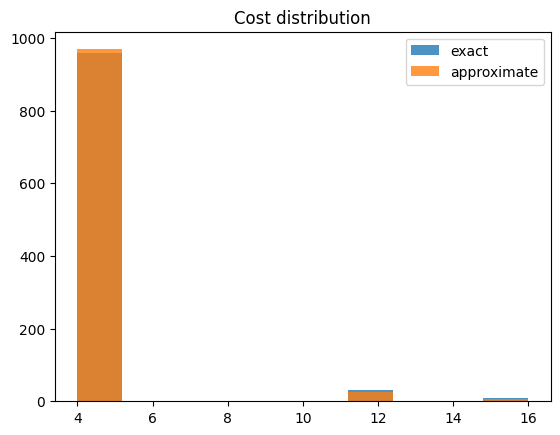

In [22]:
compare_policies(
    env = toy_env,
    policies = {
        "exact": toy_bc_policy,
        "approximate": toy_ia_policy
    },
    verbosity = 1
)

### Intermediate problem


Simulating performance for Exact policy...


100%|██████████| 1000/1000 [00:00<00:00, 1925.81it/s]


	Mean: 16.82
	Standard deviation: 2.5138814610080567

Simulating performance for Approximate policy...


100%|██████████| 1000/1000 [00:00<00:00, 2039.31it/s]


	Mean: 16.144
	Standard deviation: 1.2309606005067748


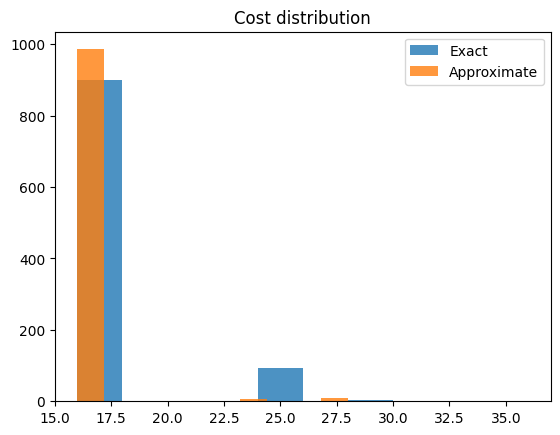

In [23]:
compare_policies(
    env = interm_env,
    policies = {
        "Exact": interm_bc_policy,
        "Approximate": interm_ia_policy
    },
    verbosity = 1
)

### Full problem

#### First, train the policies

This is going to take a while...

In [24]:
loaded_or_trained = [False, False]

In [30]:
std_env.reset()
bc_policy = BackChainPolicy(std_env)
try:
    print("Training back-chain policy...")
    bc_policy.train(
        verbosity = 1, 
        #time_limit =   TIMEOUT_AFTER_BC,
        warm_start = BC_POLICY_PATH,
        save_to = BC_POLICY_PATH
    )
    bc_policy.save(BC_POLICY_PATH)
    loaded_or_trained[0] = True
except TimeoutError as e:
    print(f"\n{e}")
    if os.path.exists(BC_POLICY_PATH):
        bc_policy.load(BC_POLICY_PATH)
        loaded_or_trained[0] = True

Training back-chain policy...
Backchain from N=12
Loaded warm start from data\bc_policy.pkl

k == 5: 792 pairs


100%|██████████| 792/792 [3:27:45<00:00, 15.74s/it]  



k == 4: 495 pairs


100%|██████████| 495/495 [1:58:56<00:00, 14.42s/it]  



k == 3: 220 pairs


100%|██████████| 220/220 [1:20:10<00:00, 21.87s/it]



k == 2: 66 pairs


 86%|████████▋ | 57/66 [18:11<02:56, 19.58s/it]

Optimization didn't work!!!
     fun: 17.09192351505742
     jac: array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        , -22.95376992,   0.        ,
       -22.95376968,   0.        , -22.95377064,   0.        ])
 message: 'Positive directional derivative for linesearch'
    nfev: 158
     nit: 15
    njev: 11
  status: 8
 success: False
       x: array([1.71594765e-15, 2.08701036e-15, 1.73284226e-15, 1.71953886e-15,
       1.68861517e-15, 1.66876383e-15, 3.31422153e-01, 1.77003549e-15,
       3.31422154e-01, 1.73642238e-15, 3.37166571e-01, 1.70648930e-15])


100%|██████████| 66/66 [22:15<00:00, 20.24s/it]



k == 1: 12 pairs


100%|██████████| 12/12 [04:18<00:00, 21.50s/it]



k == 0: 1 pairs


100%|██████████| 1/1 [00:33<00:00, 33.49s/it]


Training iterative approximation policy...
Loaded warm start from data\ia_policy.pkl
n == 11 => Already fitted
n == 10 => Already fitted
n == 9 => Already fitted
n == 8 => Already fitted
n == 7 => Already fitted
n == 6 => Already fitted
n == 5 => Already fitted
n == 4 => Already fitted
n == 3 => Already fitted
n == 2 => Already fitted
n == 1 => Already fitted
n == 0 => Already fitted

Estimated costs: [20.36339986 21.66680496 21.96631353 ...  4.          4.
  0.        ]


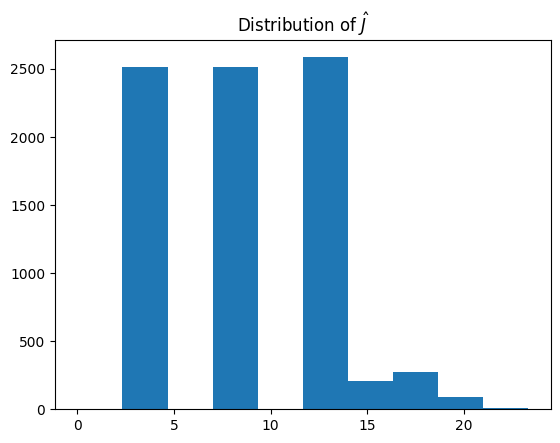

In [34]:
std_env.reset()
ia_policy = IterativeApproximationPolicy(env=std_env)
print("Training iterative approximation policy...")
try:
    ia_policy.train(
        show_hist = True, 
        verbosity = 2,
        warm_start = IA_POLICY_PATH,
        time_limit = TIMEOUT_AFTER_IA
    )
    ia_policy.save(IA_POLICY_PATH)
    loaded_or_trained[1] = True
except TimeoutError as e:
    print(f"\n{e}")
    if os.path.exists(IA_POLICY_PATH):
        ia_policy.load(IA_POLICY_PATH)
        loaded_or_trained[1] = True

#### Compare!

In [39]:
if np.all(loaded_or_trained):
    compare_policies(
        env = std_env, 
        policies = {
            "exact": bc_policy,
            "approximative": ia_policy
            },
        verbosity = 1,
        nsim = 100
    )


Simulating performance for exact policy...
